# Figure 2

DATASETS

for our methods overcluster with 15 clusters:

- Gaussians with 6 clusters in 8D, 16D, 32D, 64D
- Gaussians with 6 clusters with vaying frequency in 8D, 16D, 32D, 64D
- Worms with 6 clusters in 8D, 16D, 32D, 64D
- funky shapes with 6 clusters in 8D, 16D, 32D, 64D
- transcriptomic dataset (one mentioned in PAGA paper)

after decide on ~4-5 datasets for main figure, rest in Appendix

METHODS

- K-Means
- GMM
- TMM
- Leiden
- Agglomerative + dendrogram
- HDBSCAN
- Leiden + PAGA
- GMM + NEB
- GMM + dip-statistic
- TMM + NEB
- TMM + dip-statistic

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from corc.graph_metrics import paga, gwg, gwgmara, neb
from corc import generation, complex_datasets
import corc.utils

# import densired

from openTSNE import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
import scanpy as sc
import anndata as ad

## Tuning notes
* I tuned the number of clusters
* Affinity propagation preference was between -200 and -15_000, damping between 0.9 and 0.999
* quantile was tuned between 0.01 and 0.5 for MeanShift
* resolution was tuned between 0.01 and 1 for leaiden and paga
* Same for Optics, DBSCAN, HDBSCAN

In [3]:
class Leiden():
    def __init__(self, resolution=1.0, seed=42, use_rep='X'):
        self.resolution = resolution
        self.seed = seed
        self.use_rep = use_rep

    def fit(self, data):
        self.data = data

        counts = csr_matrix(self.data, dtype=np.float32)
        adata = ad.AnnData(counts)

        self.adata = adata

        sc.pp.neighbors(self.adata, use_rep=self.use_rep)
        # kw = {'use_rep' : self.use_rep}
        sc.tl.leiden(self.adata, flavor="igraph", n_iterations=2, resolution=self.resolution, random_state=self.seed, directed=False)

        self.labels_ = self.adata.obs['leiden']

In [16]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import studenttmixture

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from corc.complex_datasets import load_densired

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1000
seed = 30

dims = [8,16,32,64]
std = 0.075
# Gaussians with 6 clusters in 8D, 16D, 32D, 64D
blobs1_0 = complex_datasets.make_gaussians(dim=dims[0], std=std*np.sqrt(dims[0]), n_samples=n_samples)
blobs1_1 = complex_datasets.make_gaussians(dim=dims[1], std=std*np.sqrt(dims[1]), n_samples=n_samples)
blobs1_2 = complex_datasets.make_gaussians(dim=dims[2], std=std*np.sqrt(dims[2]), n_samples=n_samples)
blobs1_3 = complex_datasets.make_gaussians(dim=dims[3], std=std*np.sqrt(dims[3]), n_samples=n_samples)

# Gaussians with 6 clusters with varying frequency in 8D, 16D, 32D, 64D
blobs2_0 = complex_datasets.make_gaussians(dim=dims[0], std=std*np.sqrt(dims[0]), n_samples=n_samples, equal_sized_clusters=False)
blobs2_1 = complex_datasets.make_gaussians(dim=dims[1], std=std*np.sqrt(dims[1]), n_samples=n_samples, equal_sized_clusters=False)
blobs2_2 = complex_datasets.make_gaussians(dim=dims[2], std=std*np.sqrt(dims[2]), n_samples=n_samples, equal_sized_clusters=False)
blobs2_3 = complex_datasets.make_gaussians(dim=dims[3], std=std*np.sqrt(dims[3]), n_samples=n_samples, equal_sized_clusters=False)

# Worms with 6 clusters in 8D, 16D, 32D, 64D

# # funky shapes with 6 clusters in 8D, 16D, 32D, 64D
densired0 = complex_datasets.load_densired(dim=dims[0])
densired1 = complex_datasets.load_densired(dim=dims[1])
densired2 = complex_datasets.load_densired(dim=dims[2])
densired3 = complex_datasets.load_densired(dim=dims[3])

# MNIST-Nd
mnist0 = complex_datasets.make_mnist_nd(dim=dims[0])
mnist1 = complex_datasets.make_mnist_nd(dim=dims[1])
mnist2 = complex_datasets.make_mnist_nd(dim=dims[2])
mnist3 = complex_datasets.make_mnist_nd(dim=dims[3])

# transcriptomic dataset (one mentioned in PAGA paper)
# paul15 = make_Paul15()


# ============
# Set up cluster parameters
# ============


default_base = {
    "name": "unknown",
    "dim": 2, 
    # "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    # "preference": -200, 
    "n_neighbors": 3,
    "n_clusters": 6,
    "n_components": 15,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "resolution":1.0,
    "resolution_leiden":1.0,
    "random_state": 42,
    "use_rep":'X'
}


datasets = [
    (blobs1_0, {
        "name": "blobs1_0",
        "dim":dims[0], 
        "n_clusters": 6,
        "resolution":1.0,
        "resolution_leiden":1.0,
        "quantile" : 0.04,
        "preference": -200, 
    }),
    (blobs1_1, {
        "name": "blobs1_1",
        "dim":dims[1], 
        "n_clusters": 6,
        "resolution":1.0,
        "resolution_leiden":1.0,
        "quantile" : 0.045,
        "preference": -500, 
    }),
    (blobs1_2, {
        "name": "blobs1_2",
        "dim":dims[2], 
        "n_clusters": 6,
        "resolution":1.0,
        "resolution_leiden":1.0,
        "quantile" : 0.033,
        "preference": -700, 
    }),
    (blobs1_3, {
        "name": "blobs1_3",
        "dim":dims[3], 
        "n_clusters": 6,
        "resolution":1.0,
        "resolution_leiden":1.0,
        "quantile" : 0.031,
        "preference": -1300, 
    }),
    (blobs2_0, {
        "name": "blobs2_0",
        "dim":dims[0], 
        "n_clusters": 6,
        "resolution": 0.6,
        "resolution_leiden": 0.6,
        "quantile" : 0.07,
        "preference": -200, 
    }),
    (blobs2_1, {
        "name": "blobs2_1",
        "dim":dims[1], 
        "n_clusters": 6,
        "resolution": 0.7,
        "resolution_leiden": 0.7,
        "quantile" : 0.052, # I did not managed to get the exact same number of clusters, its the closes one above
        "preference": -500, 
    }),
    (blobs2_2, {
        "name": "blobs2_2",
        "dim":dims[2], 
        "n_clusters": 6,
        "resolution": 0.85,
        "resolution_leiden": 0.85,
        "quantile" : 0.06,
         "preference": -900, 
    }),
    (blobs2_3, {
        "name": "blobs2_3",
        "dim":dims[3], 
        "n_clusters": 6,
        "resolution": 0.93,
        "resolution_leiden": 0.93,
        "quantile" : 0.045,
         "preference": -900, 
    }),
    (densired0, {
        "dim":dims[0], 
        "n_clusters": 6,
        "resolution": 0.2,
        "resolution_leiden": 0.2,
        "quantile" : 0.03,
         "preference": -2000, 
    }),
    (densired1, {
        "dim":dims[1], 
        "n_clusters": 6,
        "resolution": 0.2,
        "resolution_leiden": 0.2,
        "quantile" : 0.04,
         "preference": -7000, 
    }),
    (densired2, {
        "dim":dims[2], 
        "n_clusters": 6,
        "resolution": 0.1,
        "resolution_leiden": 0.1,
        "quantile" : 0.035,
        "preference": -7000, 
    }),
    (densired3, {
        "dim":dims[3], 
        "n_clusters": 6,
        "resolution": 0.1,
        "resolution_leiden": 0.1,
        "quantile" : 0.052,
        "preference": -14_000, 
    }),
    (mnist0, {
        "name": "mnist0",
        "dim":dims[0], 
        "n_clusters": 15,
        "resolution": 0.6,
        "resolution_leiden": 0.6,
        "quantile" : 0.023,
        "preference": -1500, # -2000 would work as well, 
    }),
    (mnist1, {
        "name": "mnist1",
        "dim":dims[1], 
        "n_clusters": 15,
        "resolution": 0.7,
        "resolution_leiden": 0.7,
        "quantile" : 0.02,
        "preference": -3500, 
    }),
    (mnist2, {
        "name": "mnist2",
        "dim":dims[2], 
        "n_clusters": 15,
        "resolution": 0.4,
        "resolution_leiden": 0.4,
        "quantile" : 0.041,
        "preference": -5300, 
    }),
    (mnist3, {
        "name": "mnist3",
        "dim":dims[3], 
        "n_clusters": 15,
        "resolution": 0.49,
        "resolution_leiden": 0.49,
        "quantile" : 0.13,
        "preference": -6_000, 
    }),

    # (paul15, {"dim":1000, "n_clusters": 12, "n_components":20}),
]

## These are sanity checks for the parameters

In [17]:
datasets_to_tune = []
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    y = np.array(y, dtype='int')

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    leiden = Leiden(
        resolution=params["resolution_leiden"], 
        seed=params["random_state"],
        use_rep=params['use_rep'],
    )
    mpaga = paga.PAGA(
        latent_dim=params["dim"], 
        resolution=params["resolution"], 
        seed=params["random_state"],
        use_rep=params['use_rep'],
    )

    clustering_algorithms = (
        ("Leiden", leiden),
        ("PAGA", mpaga),
    )
    
    for name, algorithm in clustering_algorithms:
        algorithm.fit(X)

    # predicting and plotting
    
    
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            try:
                if hasattr(algorithm, "predict_with_target"): # merge until target number of classes is reached
                    y_pred = algorithm.predict_with_target(X,len(np.unique(y))).astype(int)
                else:
                    y_pred = algorithm.predict(X)
            except ValueError as e:
                print('some bullshit')
                y_pred = np.array([0]*len(y))
        print(i_dataset, name, len(set(y_pred)), len(set(y)))
        if len(set(y_pred)) != len(set(y)):
            datasets_to_tune.append((i_dataset, name, len(set(y_pred)), len(set(y))))
    



0 Leiden 6 6
0 PAGA 6 6
1 Leiden 6 6
1 PAGA 6 6
2 Leiden 6 6
2 PAGA 6 6
3 Leiden 6 6
3 PAGA 6 6
4 Leiden 6 6
4 PAGA 6 6
5 Leiden 6 6
5 PAGA 6 6
6 Leiden 6 6
6 PAGA 6 6
7 Leiden 6 6
7 PAGA 6 6
8 Leiden 6 6
8 PAGA 6 6
9 Leiden 6 6
9 PAGA 6 6
10 Leiden 6 6
10 PAGA 6 6
11 Leiden 6 6
11 PAGA 6 6
12 Leiden 10 10
12 PAGA 10 10
13 Leiden 10 10
13 PAGA 10 10
14 Leiden 10 10
14 PAGA 10 10
15 Leiden 10 10
15 PAGA 10 10


In [18]:
set([i[0] for i in datasets_to_tune])

set()

In [19]:
datasets_to_tune

[]

In [20]:
datasets_to_tune2 = []

for i_dataset in range(1, 16):
    dataset, algo_params = datasets[i_dataset]
    
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    y = np.array(y, dtype='int')

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("affinity_propagation", affinity_propagation),
    )
    
    for name, algorithm in clustering_algorithms:
        algorithm.fit(X)

    # predicting and plotting
    
    
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            try:
                if hasattr(algorithm, "predict_with_target"): # merge until target number of classes is reached
                    y_pred = algorithm.predict_with_target(X,len(np.unique(y))).astype(int)
                else:
                    y_pred = algorithm.predict(X)
            except ValueError as e:
                print('some bullshit')
                y_pred = np.array([0]*len(y))
        print(i_dataset, name, len(set(y_pred)), len(set(y)))
        if len(set(y_pred)) != len(set(y)):
            datasets_to_tune2.append((i_dataset, name, len(set(y_pred)), len(set(y))))

1 affinity_propagation 6 6
2 affinity_propagation 6 6
3 affinity_propagation 6 6
4 affinity_propagation 6 6
5 affinity_propagation 6 6
6 affinity_propagation 6 6
7 affinity_propagation 6 6
8 affinity_propagation 6 6
9 affinity_propagation 6 6
10 affinity_propagation 6 6
11 affinity_propagation 6 6
12 affinity_propagation 10 10
13 affinity_propagation 10 10
14 affinity_propagation 11 10
15 affinity_propagation 10 10


In [21]:
datasets_to_tune2

[(14, 'affinity_propagation', 11, 10)]

In [22]:
set([i[0] for i in datasets_to_tune2])

{14}

In [23]:
datasets_to_tune2 = []
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    y = np.array(y, dtype='int')

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=False)
    
    clustering_algorithms = (
        ("MeanShift", ms),
    )
    
    for name, algorithm in clustering_algorithms:
        algorithm.fit(X)

    # predicting and plotting
    
    
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            try:
                if hasattr(algorithm, "predict_with_target"): # merge until target number of classes is reached
                    y_pred = algorithm.predict_with_target(X,len(np.unique(y))).astype(int)
                else:
                    y_pred = algorithm.predict(X)
            except ValueError as e:
                print('some bullshit')
                y_pred = np.array([0]*len(y))
        print(i_dataset, name, len(set(y_pred)), len(set(y)))
        if len(set(y_pred)) != len(set(y)):
            datasets_to_tune2.append((i_dataset, name, len(set(y_pred)), len(set(y))))

0 MeanShift 6 6
1 MeanShift 6 6
2 MeanShift 6 6
3 MeanShift 6 6
4 MeanShift 6 6
5 MeanShift 5 6
6 MeanShift 6 6
7 MeanShift 6 6
8 MeanShift 6 6
9 MeanShift 6 6
10 MeanShift 6 6
11 MeanShift 6 6
12 MeanShift 10 10
13 MeanShift 10 10
14 MeanShift 10 10
15 MeanShift 10 10


In [24]:
datasets_to_tune2

[(5, 'MeanShift', 5, 6)]

In [25]:
set([i[0] for i in datasets_to_tune2])

{5}

## End of sanity checks

In [37]:
dbscan = cluster.DBSCAN(eps=params["eps"], min_samples=5, leaf_size=30) ## change accordingly

hdbscan = cluster.HDBSCAN(
    min_samples=params["hdbscan_min_samples"],
    min_cluster_size=params["hdbscan_min_cluster_size"],
    allow_single_cluster=params["allow_single_cluster"],
    max_cluster_size
)

optics = cluster.OPTICS(
    min_samples=params["min_samples"],
    xi=params["xi"],
    min_cluster_size=params["min_cluster_size"],
)

affinity_propagation = cluster.AffinityPropagation(
    damping=params["damping"],
    # preference=params["preference"],
    random_state=params["random_state"],
)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

NameError: name 'params' is not defined

In [9]:
tsne_cache = dict()

Dataset mnist1
loaded TSNE fit for mnist1
algorithm GMM-NEB

gmm: 100%|██████████| 105/105 [00:17<00:00,  5.84it/s]


 (fit in 19.48 seconds)
done with predictions
got the graph
transformed means
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)
transforming a path of shape (100, 16)


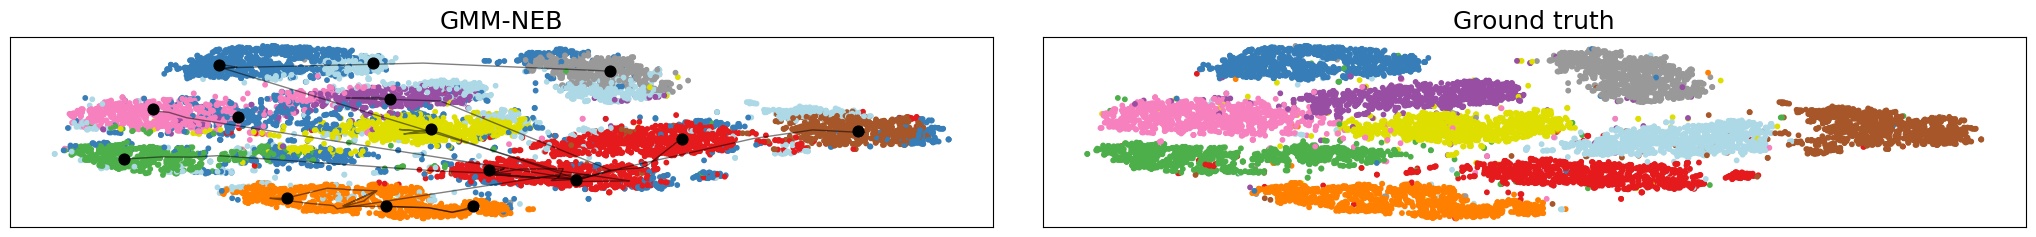

In [45]:
num_algorithms = 9
plt.figure(figsize=(num_algorithms * 2 + 3, len(datasets) * 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    print(f"Dataset {algo_params['name']}")
    starttime = time.time()
    
    X, y = dataset
    y = np.array(y, dtype='int')

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # dimensionality reduction for plotting results in 2D
    if algo_params['name'] in  tsne_cache.keys():
        X2D = tsne_cache[algo_params['name']]
        print(f"loaded TSNE fit for {algo_params['name']}")
    else:
        perplexity = 100 if dataset in ["Paul15"] else 30
        tsne = TSNE(
                perplexity=perplexity,
                metric='euclidean',
                n_jobs=8,
                random_state=42,
                verbose=False,
            )
        X2D = tsne.fit(X)

        if algo_params["name"] != "unknown":
            tsne_cache[algo_params["name"]] = X2D
        print(f"finished TSNE fit for {algo_params['name']} in {time.time()-starttime:.2f} seconds")

    

    # eps = 2.0
    # plotrange_x = np.min(X2D, axis=0)[0] - eps, np.max(X2D, axis=0)[0] + eps
    # plotrange_y = np.min(X2D, axis=0)[1] - eps, np.max(X2D, axis=0)[1] + eps

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=False)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    leiden = Leiden(
        resolution=params["resolution_leiden"], 
        seed=params["random_state"]
        )
    mpaga = paga.PAGA(
        latent_dim=params["dim"], 
        resolution=params["resolution"], 
        seed=params["random_state"]
        )
    # mgwgmara = gwgmara.GWGMara(
    #     latent_dim=params["dim"], 
    #     n_components=params["n_components"], 
    #     n_neighbors = params["n_neighbors"],
    #     seed=params["random_state"]
    #     )
    # mgwg = gwg.GWG(
    #     latent_dim=params["dim"], 
    #     n_components=params["n_components"],#params["n_clusters"],
    #     n_neighbors = params["n_neighbors"],
    #     seed=params["random_state"]
    #     )
    # tmm_neb = neb.NEB(
    #     latent_dim=params["dim"],
    #     n_components=params["n_components"],
    #     seed=params["random_state"],
    #     mixture_model_type="tmm",
    #     n_init=1,
    #     optimization_iterations=50,
    # )
    # gmm_neb = neb.NEB(
    #     latent_dim=params["dim"],
    #     n_components=params["n_components"],
    #     seed=params["random_state"],
    #     mixture_model_type="gmm",
    #     n_init=5,
    #     optimization_iterations=50,
    # )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Agglomerative\nClustering", average_linkage),
        ("HDBSCAN", hdbscan),
        # ("Gaussian\nMixture", gmm),
        # ("t-Student\nMixture", tmm),
        ("Leiden", leiden),
        ("PAGA", mpaga),
        # ("GWG-dip", mgwgmara),
        # ("GWG-pvalue", mgwg),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        # ("TMM-NEB", tmm_neb),
        # ("GMM-NEB", gmm_neb),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        print(f"algorithm {name}", end='')

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        print(f" (fit in {t1 - t0:.2f} seconds)")

        # predicting and plotting
        
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            try:
                if hasattr(algorithm, "predict_with_target"): # merge until target number of classes is reached
                    y_pred = algorithm.predict_with_target(X,len(np.unique(y))).astype(int)
                else:
                    y_pred = algorithm.predict(X)
            except ValueError as e:
                y_pred = np.array([0]*len(y))
        
        print("done with predictions")
                            

        plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                            "#add8e6",
                            "#006400",
                        ]
                    ),
                    int(max(max(y_pred), max(y)) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X2D[:, 0], X2D[:, 1], s=10, color=colors[corc.utils.reorder_colors(y_pred,y)])

        if name in ["GWG-dip", "GWG-pvalue", "PAGA", "TMM-NEB", "GMM-NEB"]:
            algorithm.plot_graph(transformation=X2D)

        # plt.xlim(plotrange_x[0], plotrange_x[1])
        # plt.ylim(plotrange_y[0], plotrange_y[1])
        plt.xticks(())
        plt.yticks(())
        # plt.text(
        #     0.99,
        #     0.01,
        #     ("%.2fs" % (t1 - t0)).lstrip("0"),
        #     transform=plt.gca().transAxes,
        #     size=15,
        #     horizontalalignment="right",
        # )
        plot_num += 1
        

    # plot ground truth
    plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
    if i_dataset == 0:
        plt.title('Ground truth', size=18)
    plt.scatter(X2D[:, 0], X2D[:, 1], s=10, color=colors[y])
    plt.xticks(())
    plt.yticks(())
    plot_num += 1

plt.show()